In [839]:
from catboost import CatBoostRegressor
from datetime import datetime, timedelta
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from matplotlib import pyplot
from matplotlib.pylab import rcParams
from pandas import DataFrame
from pmdarima.arima import auto_arima, ARIMA
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, explained_variance_score, mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from statistics import mean
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tqdm import tqdm, tqdm_notebook
from tqdm.notebook import trange, tqdm, tnrange
from xgboost import plot_importance, plot_tree, XGBClassifier
from xgboost.sklearn import XGBClassifier
import datetime as dt
import getpass
import graphviz
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pmdarima as pm
import pycountry
import pycountry_convert as pc
import pydotplus
import pyodbc 
import seaborn as sns
import sklearn.linear_model as lm
import statsmodels.api as sm
import warnings
import xgboost as xgb
pd.options.display.float_format = '{:.2f}'.format   
pd.plotting.register_matplotlib_converters()
rcParams['figure.figsize'] = 15, 5
warnings.filterwarnings('ignore')

## Data load

In [840]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df = pd.read_csv(url)
df = pd.melt(df, id_vars=['Province/State', 'Country/Region','Lat','Long'], var_name='Date', value_name='Confirmed')
df['Date'] = pd.to_datetime(df['Date'])
df.head(5)

,Province/State,Country/Region,Lat,Long,Date,Confirmed
0,NaN,Afghanistan,33.00,65.00,2020-01-22,0
1,NaN,Albania,41.15,20.17,2020-01-22,0
2,NaN,Algeria,28.03,1.66,2020-01-22,0
3,NaN,Andorra,42.51,1.52,2020-01-22,0
4,NaN,Angola,-11.20,17.87,2020-01-22,0


In [841]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22176 entries, 0 to 22175
Data columns (total 6 columns):
Province/State    6888 non-null object
Country/Region    22176 non-null object
Lat               22176 non-null float64
Long              22176 non-null float64
Date              22176 non-null datetime64[ns]
Confirmed         22176 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 1.0+ MB


In [842]:
df = df.rename(columns={'Province/State': 'Province', 'Country/Region': 'Country'})
df.shape

(22176, 6)

In [843]:
df_worldwide = pd.DataFrame(df.groupby('Date')['Confirmed'].sum())
df_worldwide['Date'] = df_worldwide.index
df_worldwide = df_worldwide.reset_index(drop=True)
df_worldwide['Country'] = 'Worldwide'
df = df.append(df_worldwide)

In [844]:
df['Province_and_country'] = df['Country'].map(str) + "_" + df['Province'].map(str)
df['Province_and_country'] = df['Province_and_country'].str.replace('_nan', '').map(str)

In [845]:
df['Days_since_outbreak_global'] = df.groupby(['Province_and_country','Lat','Long']).cumcount()+1

In [846]:
df.head()

,Confirmed,Country,Date,Lat,Long,Province,Province_and_country,Days_since_outbreak_global
0,0,Afghanistan,2020-01-22,33.00,65.00,NaN,Afghanistan,1
1,0,Albania,2020-01-22,41.15,20.17,NaN,Albania,1
2,0,Algeria,2020-01-22,28.03,1.66,NaN,Algeria,1
3,0,Andorra,2020-01-22,42.51,1.52,NaN,Andorra,1
4,0,Angola,2020-01-22,-11.20,17.87,NaN,Angola,1


In [847]:
df.to_csv('df_m.CSV',sep=',')

## Analysis - Amount of cases

In [848]:
len(df['Province_and_country'].unique())

265

In [849]:
len(df['Country'].unique())

186

In [850]:
len(df['Province'].unique())

83

In [851]:
df.describe()

,Confirmed,Lat,Long,Days_since_outbreak_global
count,22260.00,22176.00,22176.00,22260.00
mean,2803.00,21.32,22.17,42.50
std,42485.12,24.69,70.54,24.25
min,-1.00,-51.80,-135.00,1.00
25%,0.00,6.97,-20.03,21.75
50%,2.00,23.49,20.54,42.50
75%,107.00,41.17,78.75,63.25
max,1976191.00,71.71,178.06,84.00


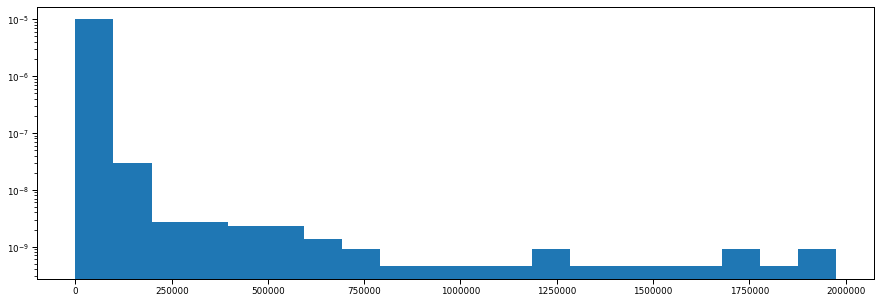

In [852]:
plt.hist(df['Confirmed'], density=True, bins=20) 
plt.yscale('log')

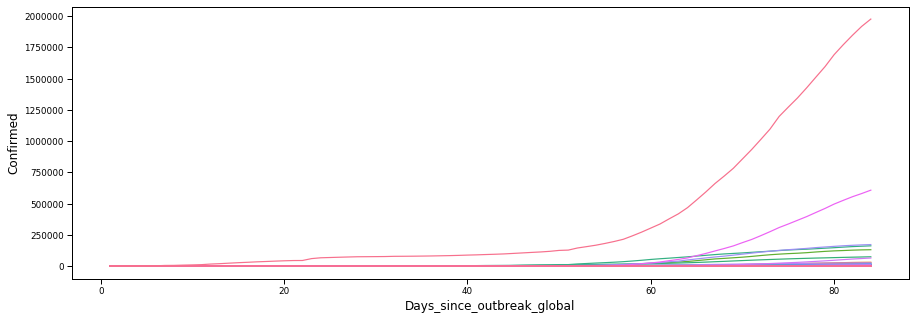

In [853]:
ax=sns.lineplot(data=df, hue="Country", x="Days_since_outbreak_global", y="Confirmed", ci=None)
ax.legend_.remove()

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...    75  \
Country                                                             ...         
Afghanistan                  0   0   0   0   0   0   0   0   0   0  ...   349   
Albania                      0   0   0   0   0   0   0   0   0   0  ...   361   
Algeria                      0   0   0   0   0   0   0   0   0   0  ...  1320   
Andorra                      0   0   0   0   0   0   0   0   0   0  ...   501   
Angola                       0   0   0   0   0   0   0   0   0   0  ...    14   

Days_since_outbreak_global    76    77    78    79    80    81    82    83  \
Country                                                                      
Afghanistan                  367   423   444   484   521   555   607   665   
Albania                      377   383   400   409   416   433   446   467   
Algeria                     1423  1468  1572  1666  1761  1825  1914  1983   
Andorra                      525   545   5

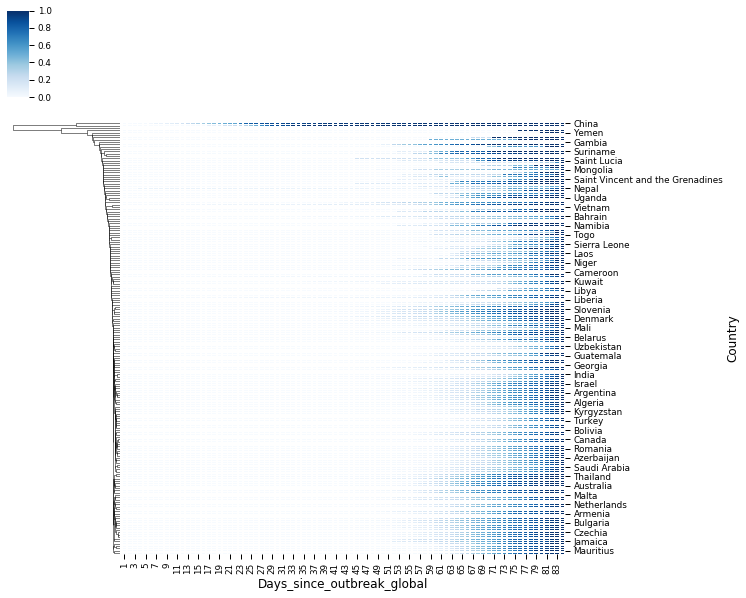

<Figure size 1800x576 with 0 Axes>

In [854]:
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":12,"axes.labelsize":12})   
def group_and_chart(Geography, Figure, Data):
    grouped = Data.groupby(['Days_since_outbreak_global',Geography])[Figure].sum()
    grouped= pd.DataFrame(grouped) 
    grouped.reset_index(inplace=True)
    grouped=grouped.pivot(index='Days_since_outbreak_global', columns=Geography, values=Figure)
    grouped = grouped.T[(grouped != 0).any()].T
    grouped = grouped.transpose()
    grouped.fillna(0, inplace=True)
    print(grouped.head())
    sns.clustermap(grouped, cmap="Blues", linewidth=.5, standard_scale=0,  col_cluster=False, method='single')
    plt.figure(figsize=(25,8))
    
group_and_chart(Geography='Country', Figure='Confirmed', Data=df)

In [855]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv'
df_country = pd.read_csv(url)
df_country = df_country.drop_duplicates(subset=['Country_Region'], keep=False)
df_country

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population
0,4,AF,AFG,4.00,nan,NaN,NaN,Afghanistan,33.94,67.71,Afghanistan,38928341.00
1,8,AL,ALB,8.00,nan,NaN,NaN,Albania,41.15,20.17,Albania,2877800.00
2,12,DZ,DZA,12.00,nan,NaN,NaN,Algeria,28.03,1.66,Algeria,43851043.00
3,20,AD,AND,20.00,nan,NaN,NaN,Andorra,42.51,1.52,Andorra,77265.00
4,24,AO,AGO,24.00,nan,NaN,NaN,Angola,-11.20,17.87,Angola,32866268.00
...,...,...,...,...,...,...,...,...,...,...,...,...
176,275,PS,PSE,275.00,nan,NaN,NaN,West Bank and Gaza,31.95,35.23,West Bank and Gaza,5101416.00
177,732,EH,ESH,732.00,nan,NaN,NaN,Western Sahara,24.22,-12.89,Western Sahara,597330.00
178,887,YE,YEM,887.00,nan,NaN,NaN,Yemen,15.55,48.52,Yemen,29825968.00
179,894,ZM,ZMB,894.00,nan,NaN,NaN,Zambia,-13.13,27.85,Zambia,18383956.00


In [856]:
# apply the mapping to df
df = pd.merge(df, df_country[['Country_Region','iso2']], left_on='Country', right_on='Country_Region', how='left')
df

,Confirmed,Country,Date,Lat,Long,Province,Province_and_country,Days_since_outbreak_global,Country_Region,iso2
0,0,Afghanistan,2020-01-22,33.00,65.00,NaN,Afghanistan,1,Afghanistan,AF
1,0,Albania,2020-01-22,41.15,20.17,NaN,Albania,1,Albania,AL
2,0,Algeria,2020-01-22,28.03,1.66,NaN,Algeria,1,Algeria,DZ
3,0,Andorra,2020-01-22,42.51,1.52,NaN,Andorra,1,Andorra,AD
4,0,Angola,2020-01-22,-11.20,17.87,NaN,Angola,1,Angola,AO
...,...,...,...,...,...,...,...,...,...,...
22255,1691719,Worldwide,2020-04-10,nan,nan,NaN,Worldwide,80,NaN,NaN
22256,1771514,Worldwide,2020-04-11,nan,nan,NaN,Worldwide,81,NaN,NaN
22257,1846679,Worldwide,2020-04-12,nan,nan,NaN,Worldwide,82,NaN,NaN
22258,1917319,Worldwide,2020-04-13,nan,nan,NaN,Worldwide,83,NaN,NaN


In [857]:
def alpha2_to_continent(iso):
    try: cont = pc.country_alpha2_to_continent_code(iso)
    except: cont = float('NaN')
    return cont

df['Continent'] = df['iso2'].apply(alpha2_to_continent) # get continent code

df.loc[df['Country'] == "Diamond Princess", 'Continent'] = "Diamond Princess"
df.loc[df['Country'] == "MS Zaandam", 'Continent'] = "MS Zaandam"
df.loc[df['Country'] == "Netherlands", 'Continent'] = "EU"
df.loc[df['Country'] == "Holy See", 'Continent'] = "AS"
df.loc[df['Country'] == "Namibia", 'Continent'] = "AF"
df.loc[df['Country'] == "Timor-Leste", 'Continent'] = "AS"
df.loc[df['Country'] == "Western Sahara", 'Continent'] = "AF"
df.loc[df['Country'] == "Worldwide", 'Continent'] = "WL"


df['Continent'] = df['Continent'].map({'WL':'Worldwide','MS Zaandam':'Ships','Diamond Princess':'Ships','AF':'Africa','AS':'Asia','EU':'Europe','NA':'North America','OC':'Oceania','SA':'South America'})

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...  \
Continent                                                           ...   
Africa                       0   0   0   0   0   0   0   0   0   0  ...   
Asia                         6  10  17  23  30  35  49  56  67  87  ...   
Europe                       0   0   0   0   0   1   4   5   5  11  ...   
North America                0   0   0   0   0   0   0   0   0   0  ...   
Oceania                      0   0   0   0   0   0   0   0   0   0  ...   

Days_since_outbreak_global      75      76      77      78      79      80  \
Continent                                                                    
Africa                        9302   10003   10636   11440   12253   12917   
Asia                        140605  151188  160616  170099  180341  191630   
Europe                      500279  519358  540541  565342  589788  615140   
North America                 6951    7575    8217    8989   10061   10977   
Oceani

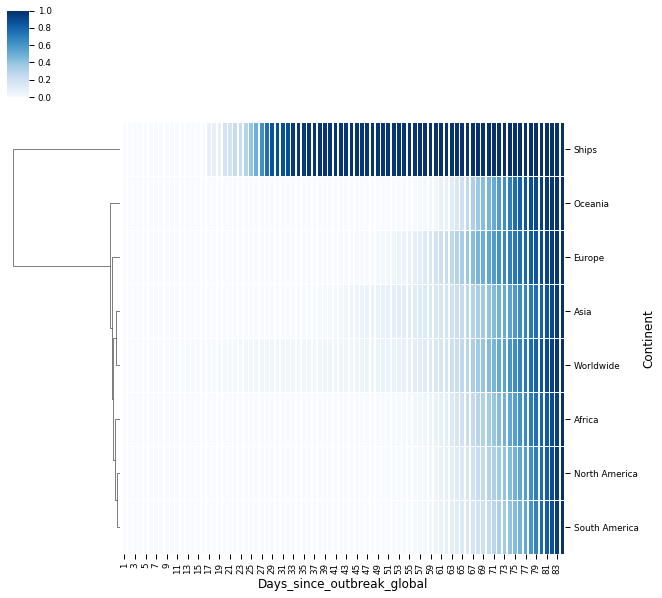

<Figure size 1800x576 with 0 Axes>

In [858]:
group_and_chart(Geography='Continent', Figure='Confirmed', Data=df)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...   75  \
Country                                                             ...        
Afghanistan                  0   0   0   0   0   0   0   0   0   0  ...  349   
Armenia                      0   0   0   0   0   0   0   0   0   0  ...  822   
Azerbaijan                   0   0   0   0   0   0   0   0   0   0  ...  584   
Bahrain                      0   0   0   0   0   0   0   0   0   0  ...  700   
Bangladesh                   0   0   0   0   0   0   0   0   0   0  ...   88   

Days_since_outbreak_global   76   77   78   79   80    81    82    83    84  
Country                                                                      
Afghanistan                 367  423  444  484  521   555   607   665   714  
Armenia                     833  853  881  921  937   967  1013  1039  1067  
Azerbaijan                  641  717  822  926  991  1058  1098  1148  1197  
Bahrain                     756  811  823  887  9

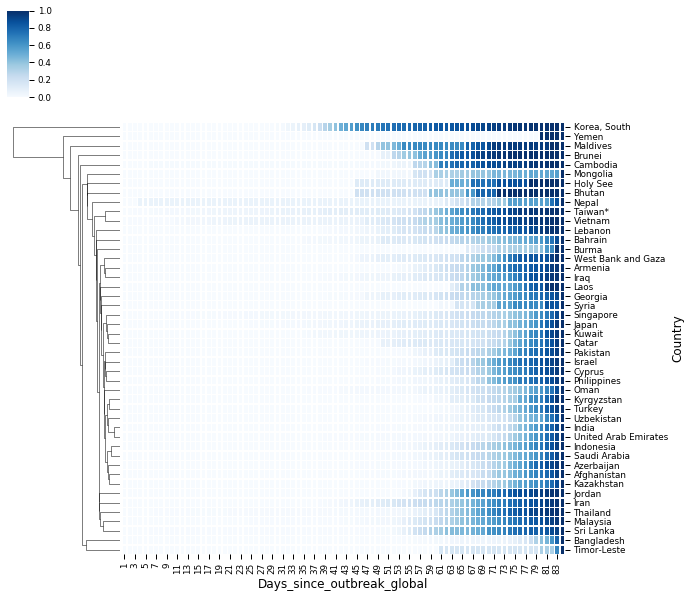

<Figure size 1800x576 with 0 Axes>

In [859]:
df_ = df.loc[(df.Continent == 'Asia')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...  \
Country                                                             ...   
Albania                      0   0   0   0   0   0   0   0   0   0  ...   
Andorra                      0   0   0   0   0   0   0   0   0   0  ...   
Austria                      0   0   0   0   0   0   0   0   0   0  ...   
Belarus                      0   0   0   0   0   0   0   0   0   0  ...   
Belgium                      0   0   0   0   0   0   0   0   0   0  ...   

Days_since_outbreak_global     75     76     77     78     79     80     81  \
Country                                                                       
Albania                       361    377    383    400    409    416    433   
Andorra                       501    525    545    564    583    601    601   
Austria                     12051  12297  12639  12942  13244  13555  13806   
Belarus                       562    700    861   1066   1486   1981   2226   


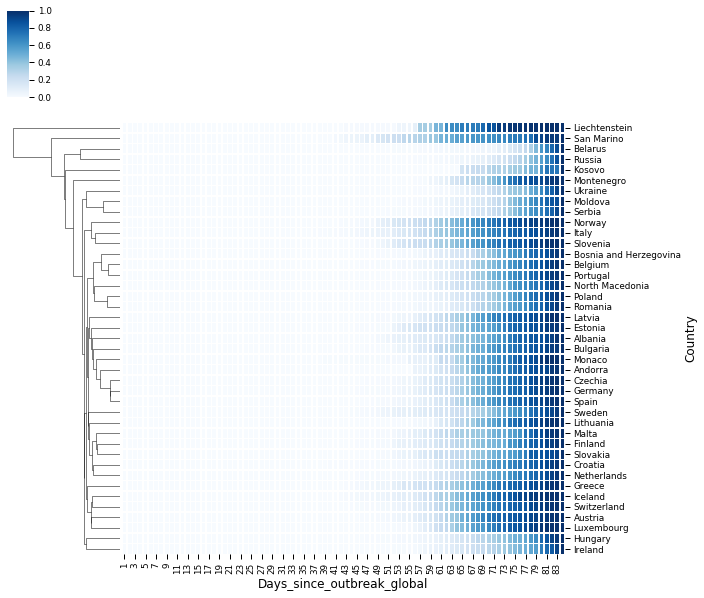

<Figure size 1800x576 with 0 Axes>

In [860]:
df_ = df.loc[(df.Continent == 'Europe')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...    75  \
Country                                                             ...         
Algeria                      0   0   0   0   0   0   0   0   0   0  ...  1320   
Angola                       0   0   0   0   0   0   0   0   0   0  ...    14   
Benin                        0   0   0   0   0   0   0   0   0   0  ...    22   
Botswana                     0   0   0   0   0   0   0   0   0   0  ...     6   
Burkina Faso                 0   0   0   0   0   0   0   0   0   0  ...   345   

Days_since_outbreak_global    76    77    78    79    80    81    82    83  \
Country                                                                      
Algeria                     1423  1468  1572  1666  1761  1825  1914  1983   
Angola                        16    17    19    19    19    19    19    19   
Benin                         26    26    26    26    35    35    35    35   
Botswana                       6     6    

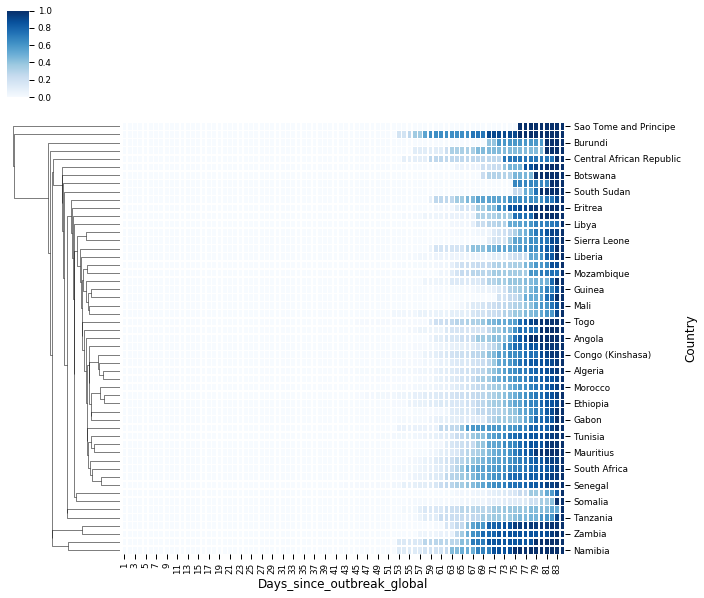

<Figure size 1800x576 with 0 Axes>

In [861]:
df_ = df.loc[(df.Continent == 'Africa')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...   75  \
Country                                                             ...        
Antigua and Barbuda          0   0   0   0   0   0   0   0   0   0  ...   15   
Bahamas                      0   0   0   0   0   0   0   0   0   0  ...   28   
Barbados                     0   0   0   0   0   0   0   0   0   0  ...   56   
Belize                       0   0   0   0   0   0   0   0   0   0  ...    5   
Costa Rica                   0   0   0   0   0   0   0   0   0   0  ...  454   

Days_since_outbreak_global   76   77   78   79   80   81   82   83   84  
Country                                                                  
Antigua and Barbuda          15   19   19   19   19   21   21   23   23  
Bahamas                      29   33   40   41   42   46   46   47   49  
Barbados                     60   63   63   66   67   68   71   72   72  
Belize                        7    7    8    9   10   13   14   18   

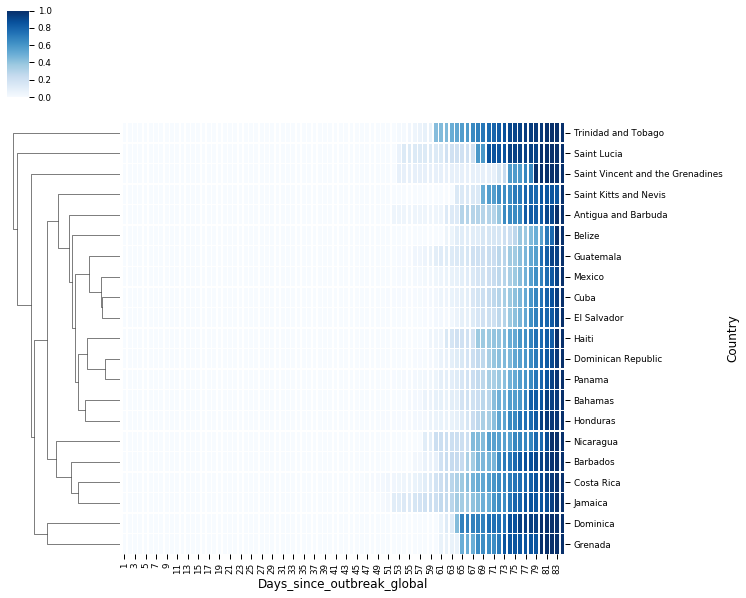

<Figure size 1800x576 with 0 Axes>

In [862]:
df_ = df.loc[(df.Continent == 'North America')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...    75  \
Country                                                             ...         
Fiji                         0   0   0   0   0   0   0   0   0   0  ...    12   
New Zealand                  0   0   0   0   0   0   0   0   0   0  ...  1039   
Papua New Guinea             0   0   0   0   0   0   0   0   0   0  ...     1   

Days_since_outbreak_global    76    77    78    79    80    81    82    83  \
Country                                                                      
Fiji                          14    15    15    15    16    16    16    16   
New Zealand                 1106  1160  1210  1239  1283  1312  1330  1349   
Papua New Guinea               2     2     2     2     2     2     2     2   

Days_since_outbreak_global    84  
Country                           
Fiji                          16  
New Zealand                 1366  
Papua New Guinea               2  

[3 rows x 84 columns]


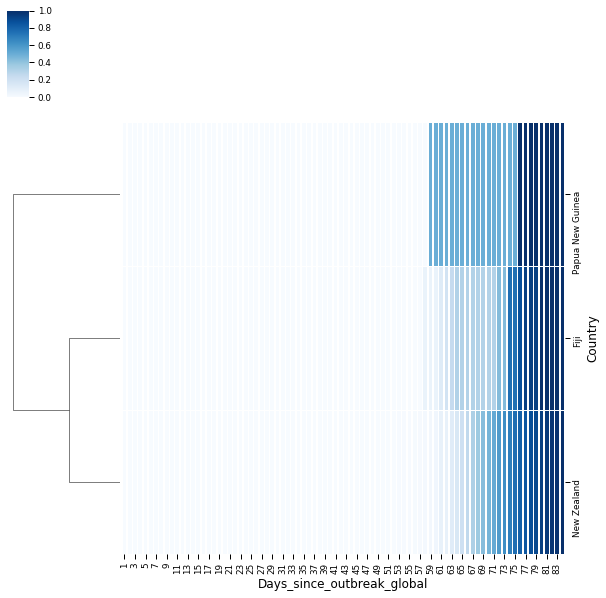

<Figure size 1800x576 with 0 Axes>

In [863]:
df_ = df.loc[(df.Continent == 'Oceania')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...  \
Country                                                             ...   
Argentina                    0   0   0   0   0   0   0   0   0   0  ...   
Bolivia                      0   0   0   0   0   0   0   0   0   0  ...   
Brazil                       0   0   0   0   0   0   0   0   0   0  ...   
Chile                        0   0   0   0   0   0   0   0   0   0  ...   
Colombia                     0   0   0   0   0   0   0   0   0   0  ...   

Days_since_outbreak_global     75     76     77     78     79     80     81  \
Country                                                                       
Argentina                    1451   1554   1628   1715   1795   1975   1975   
Bolivia                       157    183    194    210    264    268    275   
Brazil                      11130  12161  14034  16170  18092  19638  20727   
Chile                        4471   4815   5116   5546   5972   6501   6927   


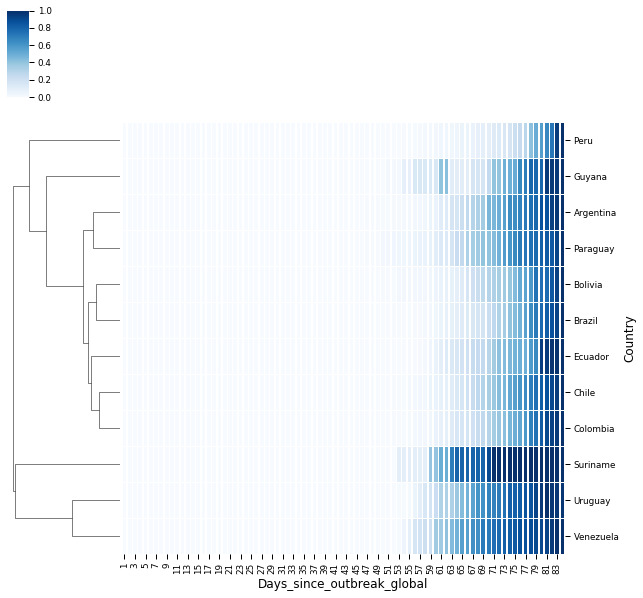

<Figure size 1800x576 with 0 Axes>

In [864]:
df_ = df.loc[(df.Continent == 'South America')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

## Analysis - daily increase

In [865]:
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday
df['Week_number'] = df['Date'].dt.week
df['Quarter'] = df['Date'].dt.quarter
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Confirmed_lag_1'] = df.groupby('Province_and_country')['Confirmed'].shift(1)
df['Daily_increase_confirmed'] = df['Confirmed']-df['Confirmed_lag_1']
df = df.replace([np.inf, -np.inf], np.nan)
#df.loc[df['Daily_increase_confirmed'] == np.inf, 'Daily_increase_confirmed'] = df['Confirmed']
#df.loc[df['Daily_increase_death'] == np.inf, 'Daily_increase_death'] = df['Deaths']
df = df.replace(np.nan, 0)
df

,Confirmed,Country,Date,Lat,Long,Province,Province_and_country,Days_since_outbreak_global,Country_Region,iso2,Continent,Day,Weekday,Week_number,Quarter,Month,Year,Confirmed_lag_1,Daily_increase_confirmed
0,0,Afghanistan,2020-01-22,33.00,65.00,0,Afghanistan,1,Afghanistan,AF,Asia,22,2,4,1,1,2020,0.00,0.00
1,0,Albania,2020-01-22,41.15,20.17,0,Albania,1,Albania,AL,Europe,22,2,4,1,1,2020,0.00,0.00
2,0,Algeria,2020-01-22,28.03,1.66,0,Algeria,1,Algeria,DZ,Africa,22,2,4,1,1,2020,0.00,0.00
3,0,Andorra,2020-01-22,42.51,1.52,0,Andorra,1,Andorra,AD,Europe,22,2,4,1,1,2020,0.00,0.00
4,0,Angola,2020-01-22,-11.20,17.87,0,Angola,1,Angola,AO,Africa,22,2,4,1,1,2020,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22255,1691719,Worldwide,2020-04-10,0.00,0.00,0,Worldwide,80,0,0,Worldwide,10,4,15,2,4,2020,1595350.00,96369.00
22256,1771514,Worldwide,2020-04-11,0.00,0.00,0,Worldwide,81,0,0,Worldwide,11,5,15,2,4,2020,1691719.00,79795.00
22257,1846679,Worldwide,2020-04-12,0.00,0.00,0,Worldwide,82,0,0,Worldwide,12,6,15,2,4,2020,1771514.00,75165.00
22258,1917319,Worldwide,2020-04-13,0.00,0.00,0,Worldwide,83,0,0,Worldwide,13,0,16,2,4,2020,1846679.00,70640.00


In [866]:
df.to_csv('df_m.CSV',sep=',')

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Afghanistan                0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Albania                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Algeria                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Andorra                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Angola                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...    75     76    77     78    79    80    81  \
Country                     ...                                               
Afghanistan                 ... 50.00  18.00 56.00  21.00 40.00 37.00 34.00   
Albania                     ... 28.00  16.00  6.00  17.00  9.00  7.00 17.00   
Algeria                     ... 69.00 103.00 45.00 104.00 94.00 95.00 64.00   
Andorra                     ... 35.00  24.00

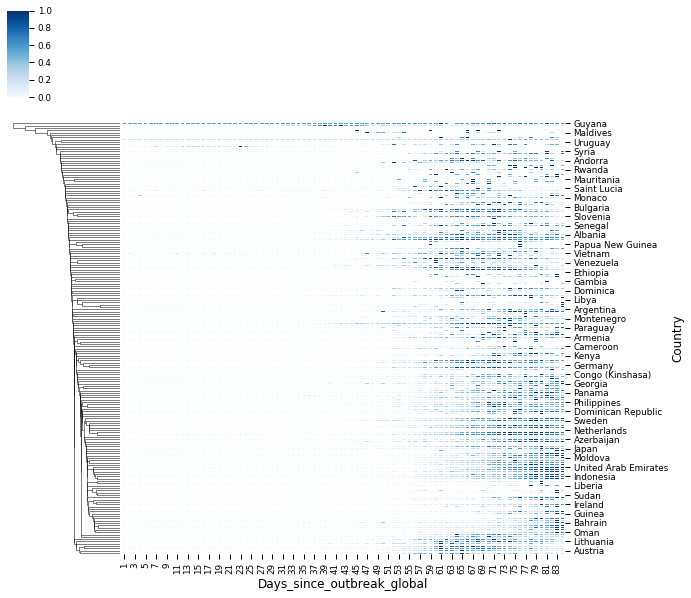

<Figure size 1800x576 with 0 Axes>

In [867]:
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df)

Days_since_outbreak_global   1     2      3      4      5      6       7   \
Continent                                                                   
0                          0.00 95.00 280.00 487.00 677.00 803.00 2634.00   
Africa                     0.00  0.00   0.00   0.00   0.00   0.00    0.00   
Asia                       0.00  4.00   7.00   6.00   7.00   5.00   14.00   
Europe                     0.00  0.00   0.00   0.00   0.00   1.00    3.00   
North America              0.00  0.00   0.00   0.00   0.00   0.00    0.00   

Days_since_outbreak_global     8       9       10  ...       75       76  \
Continent                                          ...                     
0                          580.00 2057.00 1667.00  ... 40369.00 39922.00   
Africa                       0.00    0.00    0.00  ...   710.00   701.00   
Asia                         7.00   11.00   20.00  ...  9265.00 10583.00   
Europe                       1.00    0.00    6.00  ... 21706.00 19079.00   
Nort

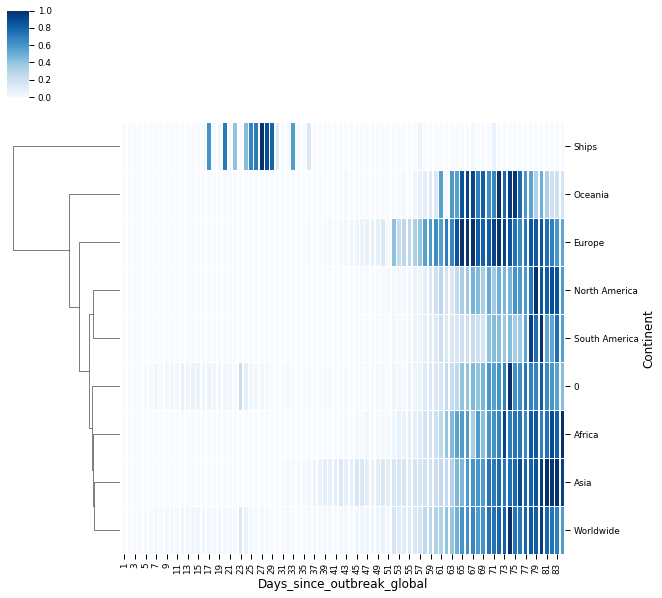

<Figure size 1800x576 with 0 Axes>

In [868]:
group_and_chart(Geography='Continent', Figure='Daily_increase_confirmed', Data=df)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Afghanistan                0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Armenia                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Azerbaijan                 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bahrain                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bangladesh                 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...    75    76    77     78     79    80     81  \
Country                     ...                                                
Afghanistan                 ... 50.00 18.00 56.00  21.00  40.00 37.00  34.00   
Armenia                     ... 52.00 11.00 20.00  28.00  40.00 16.00  30.00   
Azerbaijan                  ... 63.00 57.00 76.00 105.00 104.00 65.00  67.00   
Bahrain                     ... 12.00 5

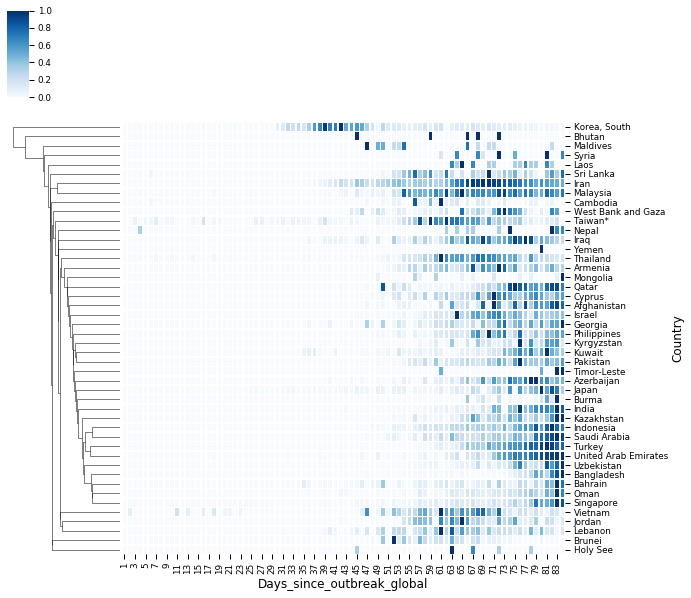

<Figure size 1800x576 with 0 Axes>

In [869]:
df_ = df.loc[(df.Continent == 'Asia')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Albania                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Andorra                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Austria                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Belarus                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Belgium                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...      75      76      77      78      79  \
Country                     ...                                           
Albania                     ...   28.00   16.00    6.00   17.00    9.00   
Andorra                     ...   35.00   24.00   20.00   19.00   19.00   
Austria                     ...  270.00  246.00  342.00  303.00  302.00   
Belarus                     ...  122.00  138.00  161.00  205.00 

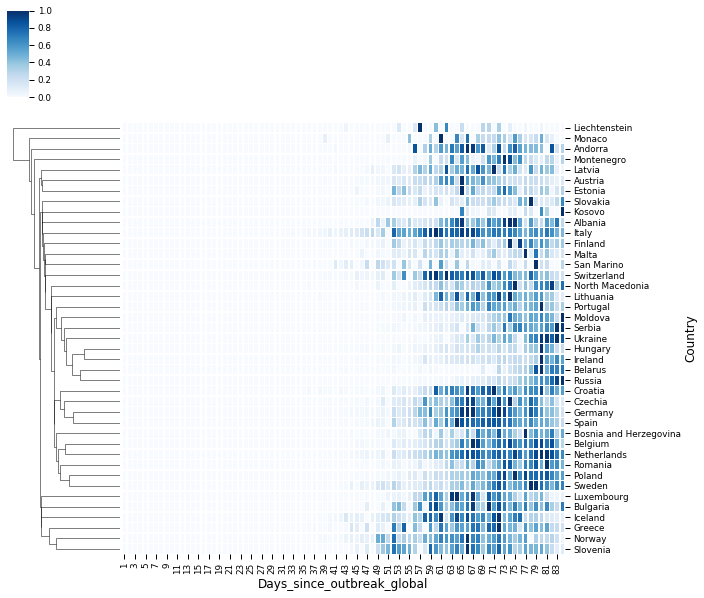

<Figure size 1800x576 with 0 Axes>

In [870]:
df_ = df.loc[(df.Continent == 'Europe')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Algeria                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Angola                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Benin                      0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Botswana                   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Burkina Faso               0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...    75     76    77     78    79    80    81  \
Country                     ...                                               
Algeria                     ... 69.00 103.00 45.00 104.00 94.00 95.00 64.00   
Angola                      ...  4.00   2.00  1.00   2.00  0.00  0.00  0.00   
Benin                       ...  6.00   4.00  0.00   0.00  0.00  9.00  0.00   
Botswana                    ...  2.00   0.00

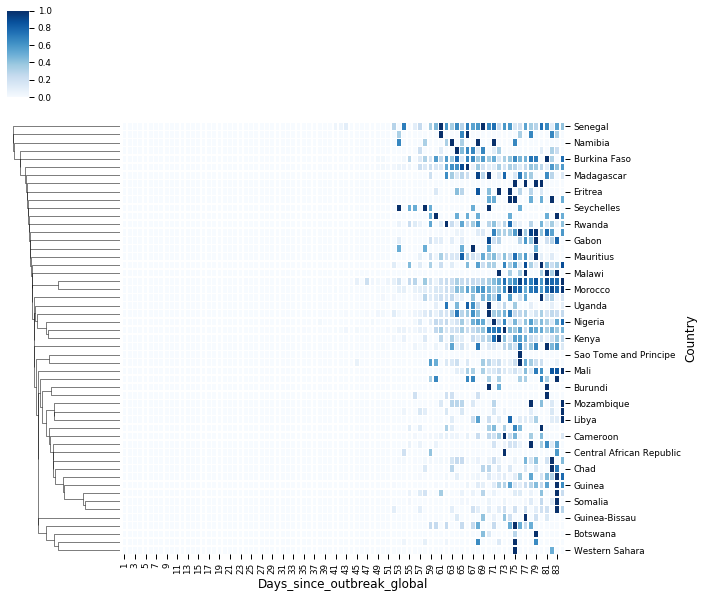

<Figure size 1800x576 with 0 Axes>

In [871]:
df_ = df.loc[(df.Continent == 'Africa')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Antigua and Barbuda        0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bahamas                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Barbados                   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Belize                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Costa Rica                 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...    75    76    77    78    79    80    81  \
Country                     ...                                             
Antigua and Barbuda         ...  0.00  0.00  4.00  0.00  0.00  0.00  2.00   
Bahamas                     ...  0.00  1.00  4.00  7.00  1.00  1.00  4.00   
Barbados                    ...  4.00  4.00  3.00  0.00  3.00  1.00  1.00   
Belize                      ...  1.00  2.00  0.00  1.0

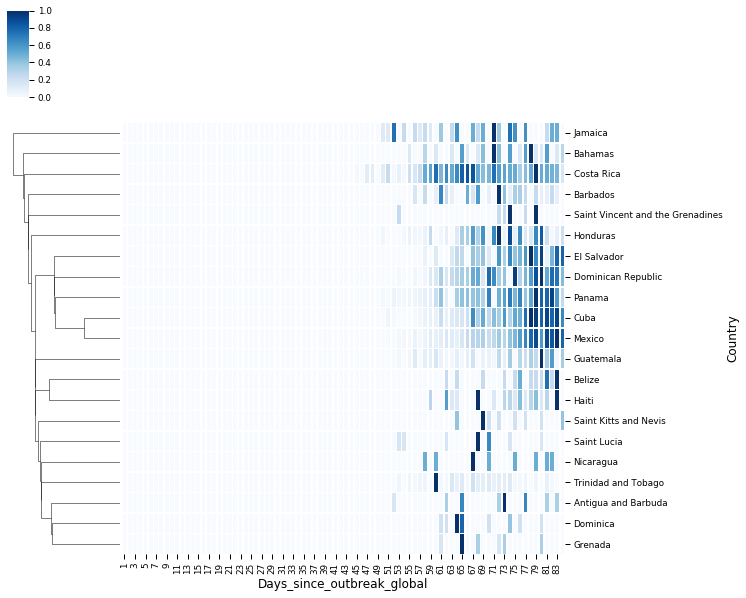

<Figure size 1800x576 with 0 Axes>

In [872]:
df_ = df.loc[(df.Continent == 'North America')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Fiji                       0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
New Zealand                0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Papua New Guinea           0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...    75    76    77    78    79    80    81  \
Country                     ...                                             
Fiji                        ...  0.00  2.00  1.00  0.00  0.00  1.00  0.00   
New Zealand                 ... 89.00 67.00 54.00 50.00 29.00 44.00 29.00   
Papua New Guinea            ...  0.00  1.00  0.00  0.00  0.00  0.00  0.00   

Days_since_outbreak_global    82    83    84  
Country                                       
Fiji                        0.00  0.00  0.00  
New Zealand                18.00 19.00 17.00  
Papua New Guinea         

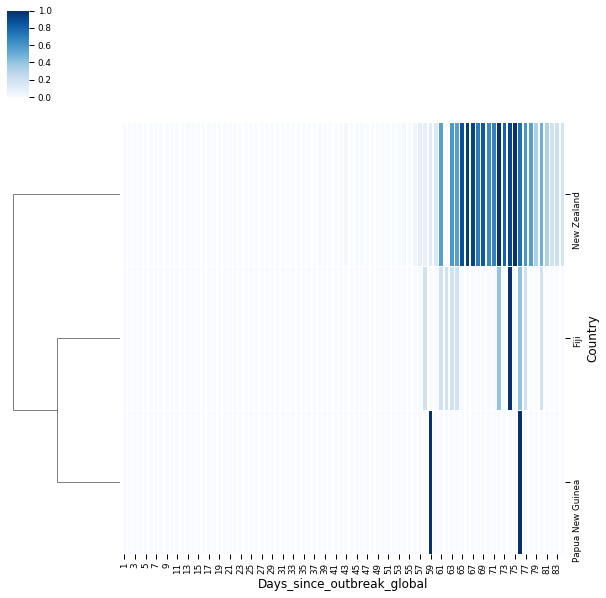

<Figure size 1800x576 with 0 Axes>

In [873]:
df_ = df.loc[(df.Continent == 'Oceania')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Argentina                  0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bolivia                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Brazil                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Chile                      0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Colombia                   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...     75      76      77      78      79  \
Country                     ...                                          
Argentina                   ...   0.00  103.00   74.00   87.00   80.00   
Bolivia                     ...  18.00   26.00   11.00   16.00   54.00   
Brazil                      ... 770.00 1031.00 1873.00 2136.00 1922.00   
Chile                       ... 310.00  344.00  301.00  430.00  426.0

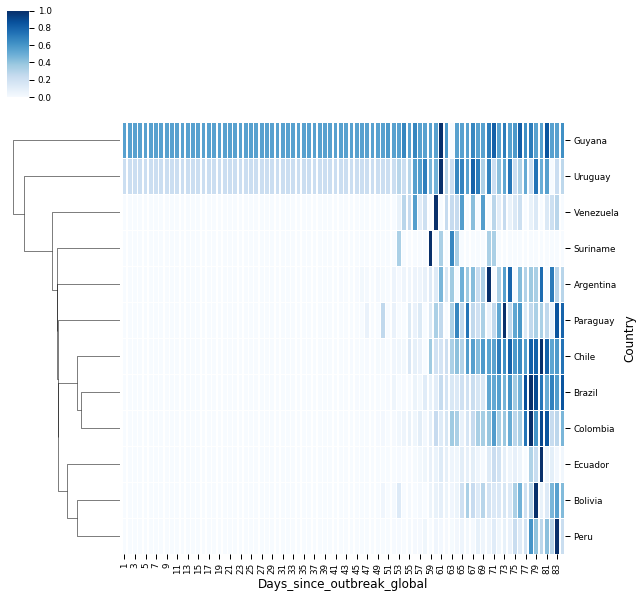

<Figure size 1800x576 with 0 Axes>

In [874]:
df_ = df.loc[(df.Continent == 'South America')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

## Prediction

In [875]:
df_ml_confirmed = df.copy()
df_ml_confirmed['Confirmed_lag_1'] = df_ml_confirmed.groupby('Province_and_country')['Confirmed'].shift(1)
df_ml_confirmed['Confirmed'] = df_ml_confirmed['Confirmed']-df_ml_confirmed['Confirmed_lag_1']
df_ml_confirmed['Confirmed_lag_7'] = df_ml_confirmed.groupby('Province_and_country')['Confirmed'].shift(7)
df_ml_confirmed['Days_since_outbreak_country'] = df_ml_confirmed.loc[(df_ml_confirmed.Confirmed.notnull())].groupby(['Province_and_country','Lat','Long']).cumcount()+1
df_ml_confirmed = df_ml_confirmed.replace(np.nan, 0)
df_ml_confirmed = df_ml_confirmed[['Confirmed', 'Province_and_country', 'Days_since_outbreak_global', 'Date','Day','Weekday','Week_number','Quarter','Month','Year','Confirmed_lag_7','Days_since_outbreak_country']]

In [876]:
df_ml_confirmed.to_csv('df_ml.CSV',sep=',')

### One Country Test

In [877]:
split_date = datetime.today() - timedelta(days=8)
split_date

datetime.datetime(2020, 4, 7, 14, 49, 54, 542335)

In [879]:
def create_x_y(df, label=None):
    df.index = df['Date']
    X = df[['Days_since_outbreak_global','Day','Weekday','Week_number','Quarter','Month','Year', 'Confirmed_lag_7','Days_since_outbreak_country']]
    if label:
        y = df[label]
        return X, y
    return X

In [880]:
def root_mean_squared_log_error(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<0 or real[x]<0: # check for negative values
            continue
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

1532.245575979903
1776.5035093294887
0.5429002237933354


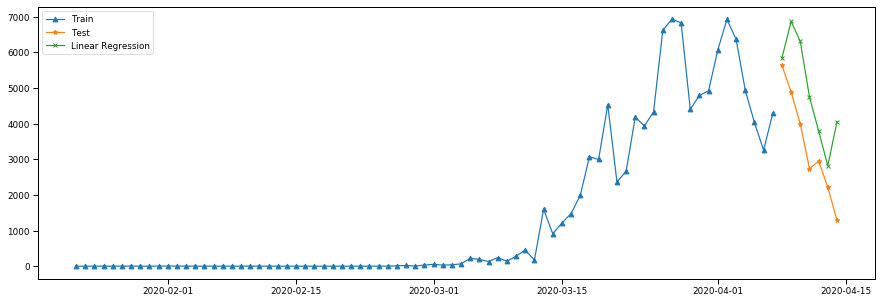

In [882]:
#Linear Regression
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]
 
Confirmed_train = List.loc[List.Date <= split_date].copy()
Confirmed_test = List.loc[List.Date > split_date].copy()

X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class

linear_regressor.fit(X_train, y_train)

Confirmed_test['Confirmed_Prediction'] = linear_regressor.predict(X_test)

plt.plot(Confirmed_train.index, Confirmed_train['Confirmed'], label='Train',marker ='^')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test', marker = "*")
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed_Prediction'], label='Linear Regression', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print(root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction']))

1549.344921984425
1842.352526794554
0.6122350977847936


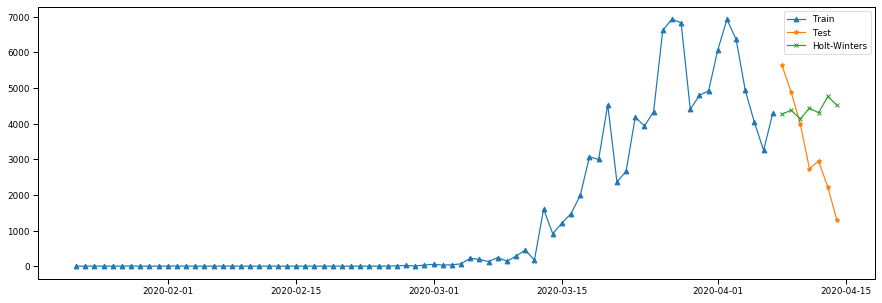

In [883]:
#Holt winters-non-optimized
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']
#List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12, damped=False) #base_model

hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

pred = hw_model.predict(start=test.index[0], end=test.index[-1])
pred = pd.DataFrame(pred)
pred.rename(columns={ pred.columns[0]: "Confirmed" }, inplace = True)

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Holt-Winters', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_squared_error(y_pred=pred, y_true=test)))
print(root_mean_squared_log_error(real=test.Confirmed, predicted=pred.Confirmed))

[None, False, 'add', 6, False, False]
1334.460467449191
1572.193809297432
0.5486323272601955


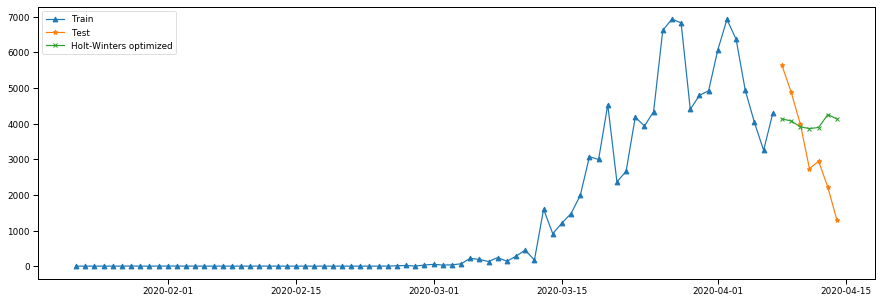

In [884]:
#Holt Winters optimized
def exp_smoothing_configs(i):
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = [0,6,12]
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

cfg_list = exp_smoothing_configs(i)

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

best_RMSE = np.inf
best_config = []
t1 = d1 = s1 = p1 = b1 = r1 = ''
for j in range(len(cfg_list)):
    try:
        cg = cfg_list[j]
        t,d,s,p,b,r = cg

        model = ExponentialSmoothing(train, trend=t, damped=d, seasonal=s, seasonal_periods=p)

        hw_model = model.fit(optimized=True, use_boxcox=b, remove_bias=r)

        pred = hw_model.predict(start=test.index[0], end=test.index[-1])

        pred = pd.DataFrame(pred)
        pred.rename(columns={ pred.columns[0]: "Confirmed" }, inplace = True)
        
        rmse = np.sqrt(mean_squared_error(y_pred=pred, y_true=test))
        
        if rmse < best_RMSE:
            best_RMSE = rmse
            best_config = cfg_list[j]
    except:
        continue

t1,d1,s1,p1,b1,r1 = best_config
print(best_config)

if t1 == None:
    model = ExponentialSmoothing(train, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    model = ExponentialSmoothing(train, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

hw_model = model.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

pred = hw_model.predict(start=test.index[0], end=test.index[-1])

pred = pd.DataFrame(pred)
pred.rename(columns={ pred.columns[0]: "Confirmed" }, inplace = True)

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Holt-Winters optimized', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_squared_error(y_pred=pred, y_true=test)))
print(root_mean_squared_log_error(real=test.Confirmed, predicted=pred.Confirmed))

1733.669419366735
1927.5543941586645
0.6142574817476402


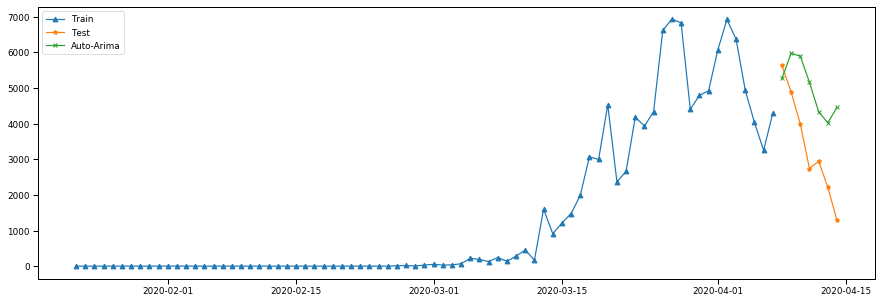

In [885]:
#Auto-Arima
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

stepwise_fit = auto_arima(train, error_action='ignore', trace=False,
                      suppress_warnings=True, seasonal=False, stepwise=True)  # set to stepwise

stepwise_fit.summary()

pred = pd.DataFrame(stepwise_fit.predict(n_periods=7), index= test.index)

pred.columns = ['Confirmed']

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Auto-Arima', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_squared_error(y_pred=pred, y_true=test)))
print(root_mean_squared_log_error(real=test.Confirmed, predicted=pred.Confirmed))

1117.497523716518
1294.1373276652523
0.43805589627527675


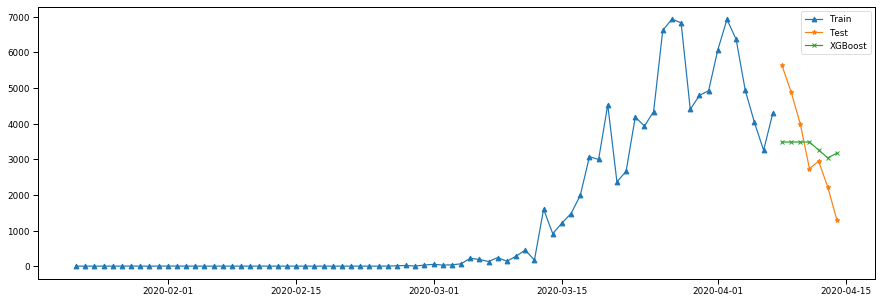

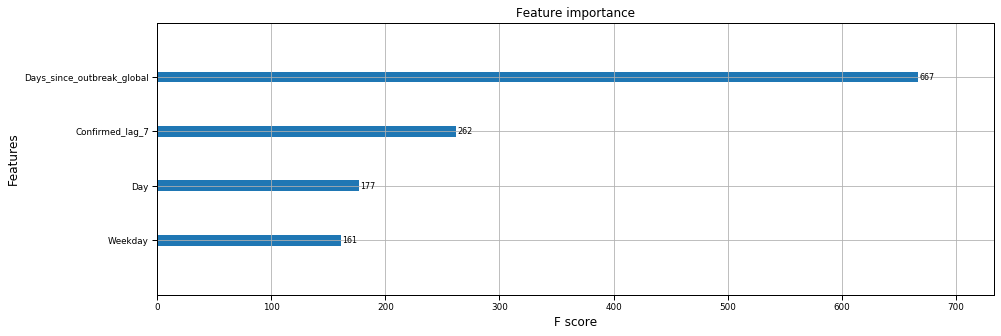

In [886]:
#XGBoost non-optimized
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]
 
Confirmed_train = List.loc[List.Date <= split_date].copy()
Confirmed_test = List.loc[List.Date > split_date].copy()

X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

reg = xgb.XGBRegressor(n_estimators=1000, objective= 'reg:squarederror')
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=200,
       verbose=False) # Change verbose to True if you want to see it train

Confirmed_test['Confirmed_Prediction'] = reg.predict(X_test)

plt.plot(Confirmed_train.index, Confirmed_train['Confirmed'], label='Train',marker ='^')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test', marker = "*")
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed_Prediction'], label='XGBoost', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print(root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction']))

plot_importance(reg)
pyplot.show()

Fitting 5 folds for each of 2700 candidates, totalling 13500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 2752 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 7280 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 13075 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 13500 out of 13500 | elapsed:   19.0s finished


1895.5038364955358
2157.0278335316934
0.673613730794355


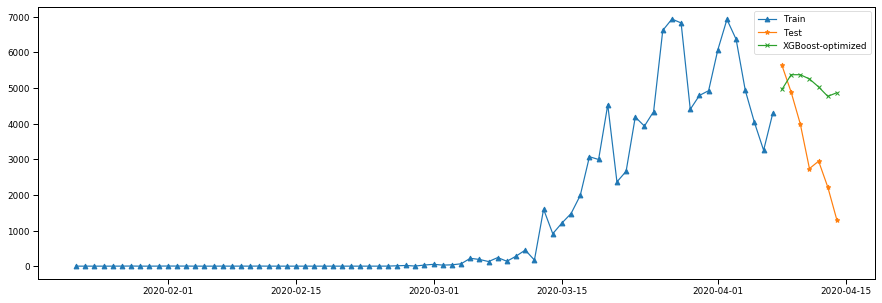

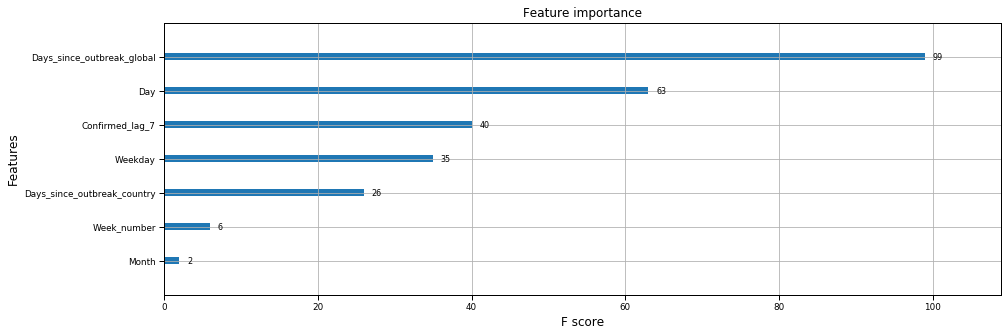

In [887]:
#XGBoost optimized
param_test = {
 'gamma':[i/10.0 for i in range(0,5)],
 'max_depth':[4,5,6],
 'min_child_weight':[6,8,10,12],
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)],
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=47, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:squarederror', nthread=-1, scale_pos_weight=1,seed=27), 
 param_grid = param_test, n_jobs=-1, iid=False, cv=5, verbose=2)
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

best_params_xgb = gsearch.best_estimator_.get_xgb_params()
xgtrain = xgb.DMatrix(data=X_train,label=y_train)
xgtest = xgb.DMatrix(X_test)
cvresult = xgb.cv(best_params_xgb, xgtrain, num_boost_round=gsearch.best_estimator_.get_xgb_params()['n_estimators'], nfold=5,
            metrics='rmse', early_stopping_rounds=200)
gsearch.best_estimator_.set_params(n_estimators=cvresult.shape[0])

#Fit the algorithm on the data
gsearch.best_estimator_.fit(X_train, y_train,eval_metric='rmse')

Confirmed_test['Confirmed_Prediction'] = gsearch.best_estimator_.predict(X_test)

plt.plot(Confirmed_train.index, Confirmed_train['Confirmed'], label='Train',marker ='^')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test', marker = "*")
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed_Prediction'], label='XGBoost-optimized', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print(root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction']))

plot_importance(gsearch.best_estimator_)
pyplot.show()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

1108.5636338582765
1288.51817507094
0.44966058757519206


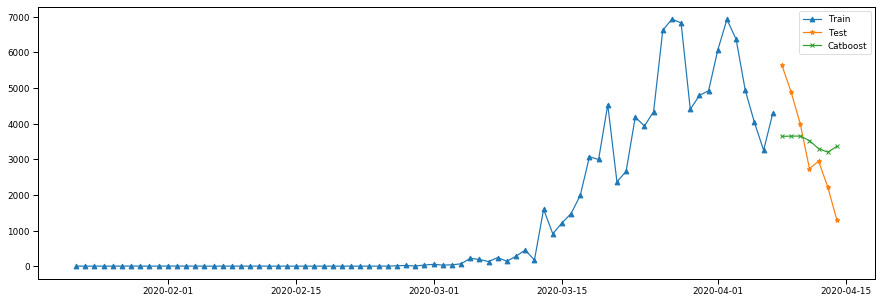

In [888]:
#Catboost non-optimized
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]
 
Confirmed_train = List.loc[List.Date <= split_date].copy()
Confirmed_test = List.loc[List.Date > split_date].copy()

X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

model = CatBoostRegressor(iterations=1000, verbose=False, loss_function='RMSE')
# Fit model
model.fit(X_train, y_train,plot=True, eval_set=(X_test, y_test))

Confirmed_test['Confirmed_Prediction'] = model.predict(X_test)

plt.plot(Confirmed_train.index, Confirmed_train['Confirmed'], label='Train',marker ='^')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test', marker = "*")
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed_Prediction'], label='Catboost', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print(root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction']))

[15/Apr/2020 14:51:19] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 14:51:19] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2586.3969534085286
2987.492981832685
0.8213611864159716


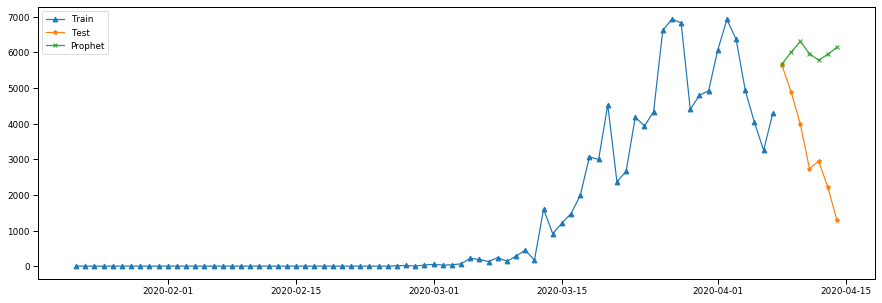

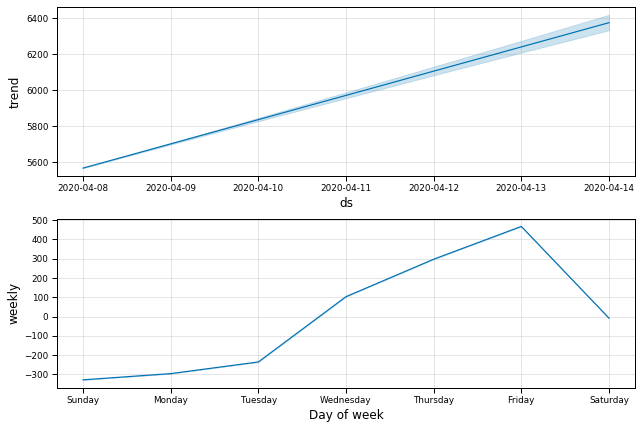

In [889]:
#Prophet
List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = train[['Confirmed','Date']]
test = test[['Confirmed','Date']]

model = Prophet()
model.fit(train.reset_index().rename(columns={'Date':'ds', 'Confirmed':'y'}))

#pred = model.predict(df=test.reset_index().rename(columns={'Date':'ds'}))
pred = pd.DataFrame(model.predict(df=test.reset_index().rename(columns={'Date':'ds'})))

#pd.DataFrame(stepwise_fit.predict(n_periods=7), index= Confirmed_test_.index)

test = test.reset_index(drop=True)
pred = pred.reset_index(drop=True)

plt.plot(train.Date, train.Confirmed, label='Train',marker ='^')
plt.plot(test.Date, test.Confirmed, label='Test', marker = "*")
plt.plot(test.Date, pred.yhat, label='Prophet', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred.yhat, y_true=test.Confirmed))
print(np.sqrt(mean_squared_error(y_pred=pred.yhat, y_true=test.Confirmed)))
print(root_mean_squared_log_error(real=test.Confirmed, predicted=pred.yhat))

fig = model.plot_components(pred)

### All customers

In [914]:
df_ml_confirmed_var = pd.DataFrame(list(dict.fromkeys(df_ml_confirmed.Province_and_country)))
df_ml_confirmed_var.rename(columns={ df_ml_confirmed_var.columns[0]: "Value" }, inplace = True)
#df_ml_confirmed_var = df_ml_confirmed_var.loc[(df_ml_confirmed_var.Value == "Canada_Diamond Princess")]
df_ml_confirmed_var = df_ml_confirmed_var.head(20)
len(df_ml_confirmed_var)

20

#### Linear Regression

In [891]:
Train_and_Test = []

In [892]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    Confirmed_train = List.loc[List.Date <= split_date].copy()
    Confirmed_test = List.loc[List.Date > split_date].copy()
    
    X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
    X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class

    linear_regressor.fit(X_train, y_train)

    Confirmed_test['Confirmed_Prediction'] = linear_regressor.predict(X_test)
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Linear Regression"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Linear = pd.concat(Train_and_Test_temp)
Train_and_Test = pd.concat(Train_and_Test_temp)


Finished!


In [893]:
Train_and_Test_Linear = Train_and_Test_Linear.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.RMSLE.notnull(), 'RMSLE']))

290.02897862748483
344.5925392516921
0.7537164492237922


#### Holt-Winters (non-optimized)

In [894]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']
    
    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    model = ExponentialSmoothing(Confirmed_train_, trend='add', seasonal='add', seasonal_periods=12, damped=False) #base_model
    hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

    Confirmed_test['Confirmed_Prediction'] = hw_model.predict(start=Confirmed_test.index[0], end=Confirmed_test.index[-1])
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Holt-Winters Non-optimized"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Holt = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_Holt)


Finished!


In [895]:
Train_and_Test_Holt = Train_and_Test_Holt.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.RMSLE.notnull(), 'RMSLE']))

154.3797087711954
190.21753187175344
0.7794818960125769


#### Holt-Winters (optimized)

In [896]:
def exp_smoothing_configs(i):
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = [0,6,12]
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

cfg_list = exp_smoothing_configs(i)

In [897]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']
    
    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    best_RMSE = np.inf
    best_config = []
    t1 = d1 = s1 = p1 = b1 = r1 = ''
    for j in range(len(cfg_list)):
        try:
            cg = cfg_list[j]
            t,d,s,p,b,r = cg

            model = ExponentialSmoothing(Confirmed_train_, trend=t, damped=d, seasonal=s, seasonal_periods=p)

            hw_model = model.fit(optimized=True, use_boxcox=b, remove_bias=r)

            Confirmed_test['Confirmed_Prediction'] = hw_model.predict(start=Confirmed_test.index[0], end=Confirmed_test.index[-1])

            rmse = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))

            if rmse < best_RMSE:
                best_RMSE = rmse
                best_config = cfg_list[j]
        except:
            continue

    t1,d1,s1,p1,b1,r1 = best_config

    if t1 == None:
        model = ExponentialSmoothing(Confirmed_train_, trend=t1, seasonal=s1, seasonal_periods=p1)
    else:
        model = ExponentialSmoothing(Confirmed_train_, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

    hw_model = model.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

    Confirmed_test['Confirmed_Prediction'] = hw_model.predict(start=Confirmed_test.index[0], end=Confirmed_test.index[-1])
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Holt-Winters Optimized"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Holt_optimized = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_Holt_optimized)


Finished!


In [898]:
Train_and_Test_Holt_optimized = Train_and_Test_Holt_optimized.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Holt_optimized.loc[Train_and_Test_Holt_optimized.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Holt_optimized.loc[Train_and_Test_Holt_optimized.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Holt_optimized.loc[Train_and_Test_Holt_optimized.RMSLE.notnull(), 'RMSLE']))

103.28286422814911
131.10498316953002
0.6629020186996768


#### Auto-ARIMA

In [899]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']

    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    stepwise_fit = auto_arima(Confirmed_train_, error_action='ignore', trace=False,
                          suppress_warnings=True, seasonal=False, stepwise=True)  # set to stepwise

    stepwise_fit.summary()

    Confirmed_test['Confirmed_Prediction'] = pd.DataFrame(stepwise_fit.predict(n_periods=7), index= Confirmed_test_.index)
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Auto-ARIMA"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_ARIMA = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_ARIMA)


Finished!


In [900]:
Train_and_Test_ARIMA = Train_and_Test_ARIMA.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.RMSLE.notnull(), 'RMSLE']))

134.79405436448232
165.19712534286074
0.7392654881570928


#### XGboost (non-optimized)

In [901]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    Confirmed_train = List.loc[List.Date <= split_date].copy()
    Confirmed_test = List.loc[List.Date > split_date].copy()
    
    X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
    X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    reg = xgb.XGBRegressor(n_estimators=1000, objective= 'reg:squarederror')
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            early_stopping_rounds=200,
           verbose=False) # Change verbose to True if you want to see it train

    Confirmed_test['Confirmed_Prediction'] = reg.predict(X_test)
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = 'XGBoost (Non-optimized)'
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_XGBoost = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_XGBoost)


Finished!


In [902]:
Train_and_Test_XGBoost = Train_and_Test_XGBoost.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_XGBoost.loc[Train_and_Test_XGBoost.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_XGBoost.loc[Train_and_Test_XGBoost.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_XGBoost.loc[Train_and_Test_XGBoost.RMSLE.notnull(), 'RMSLE']))

103.27959360372667
131.04916864496695
0.6283010430518706


#### XGboost (optimized)

In [903]:
param_test = {
     'gamma':[i/10.0 for i in range(0,5)],
     'max_depth':[4,5,6],
     'min_child_weight':[6,8,10,12],
     'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
     'subsample':[i/100.0 for i in range(75,90,5)],
     'colsample_bytree':[i/100.0 for i in range(75,90,5)],
     'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
    }

In [904]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    Confirmed_train = List.loc[List.Date <= split_date].copy()
    Confirmed_test = List.loc[List.Date > split_date].copy()
    
    X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
    X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)
    
    gsearch = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.1, n_estimators=47, max_depth=5,
     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
     objective= 'reg:squarederror', nthread=-1, scale_pos_weight=1,seed=27), 
     param_grid = param_test, n_jobs=-1, iid=False, cv=5, verbose=0)
    gsearch.fit(X_train, y_train)
    gsearch.best_params_, gsearch.best_score_

    best_params_xgb = gsearch.best_estimator_.get_xgb_params()
    xgtrain = xgb.DMatrix(data=X_train,label=y_train)
    xgtest = xgb.DMatrix(X_test)
    cvresult = xgb.cv(best_params_xgb, xgtrain, num_boost_round=gsearch.best_estimator_.get_xgb_params()['n_estimators'], nfold=5,
                metrics='rmse', early_stopping_rounds=200)
    gsearch.best_estimator_.set_params(n_estimators=cvresult.shape[0])

    #Fit the algorithm on the data
    gsearch.best_estimator_.fit(X_train, y_train,eval_metric='rmse')

    Confirmed_test['Confirmed_Prediction'] = gsearch.best_estimator_.predict(X_test)
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = 'XGBoost (Optimized)'
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_XGBoost_optimized = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_XGBoost_optimized)


Finished!


In [905]:
Train_and_Test_XGBoost_optimized = Train_and_Test_XGBoost_optimized.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_XGBoost_optimized.loc[Train_and_Test_XGBoost_optimized.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_XGBoost_optimized.loc[Train_and_Test_XGBoost_optimized.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_XGBoost_optimized.loc[Train_and_Test_XGBoost_optimized.RMSLE.notnull(), 'RMSLE']))

132.6546734120486
160.95960973334434
0.7860749811396905


#### CatBoost

In [906]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    try:
    
        List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]

        Confirmed_train = List.loc[List.Date <= split_date].copy()
        Confirmed_test = List.loc[List.Date > split_date].copy()

        X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
        X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

        X_train = X_train.fillna(0)
        X_test = X_test.fillna(0)

        model = CatBoostRegressor(iterations=1000, verbose=False)
        model.fit(X_train, y_train)

        Confirmed_test['Confirmed_Prediction'] = model.predict(X_test)

        Confirmed_test['File_type'] = "Test"
        Confirmed_train['File_type'] = "Train"

        Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)

        Train_and_Test_['Model'] = 'CatBoost'

        Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

        Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))

        Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])

        Train_and_Test_temp.append(Train_and_Test_)
        
    except Exception as e: 
        pass
    
print("Finished!")

Train_and_Test_CatBoost = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_CatBoost)


Finished!


In [907]:
Train_and_Test_CatBoost = Train_and_Test_CatBoost.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_CatBoost.loc[Train_and_Test_CatBoost.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_CatBoost.loc[Train_and_Test_CatBoost.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_CatBoost.loc[Train_and_Test_CatBoost.RMSLE.notnull(), 'RMSLE']))

117.71954803769067
146.50240863424892
0.7965448299444348


#### Prophet

In [908]:
Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']

    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)
    
    Confirmed_train_ = Confirmed_train[['Confirmed','Date']]
    Confirmed_test_ = Confirmed_test[['Confirmed','Date']]

    model = Prophet()
    model.fit(Confirmed_train_.reset_index(drop=True).rename(columns={'Date':'ds', 'Confirmed':'y'}))

    Confirmed_pred = model.predict(df=Confirmed_test_.reset_index(drop=True).rename(columns={'Date':'ds'}))
    
    Confirmed_test.index.name = None
    Confirmed_test = pd.merge(Confirmed_test, Confirmed_pred[['ds','yhat']], left_on='Date', right_on='ds', how='left').rename(columns={'yhat':'Confirmed_Prediction'}).drop(columns=['ds'])
            
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Prophet"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_squared_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['RMSLE'] = root_mean_squared_log_error(real=Confirmed_test['Confirmed'], predicted=Confirmed_test['Confirmed_Prediction'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Prophet = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_Prophet)

[15/Apr/2020 16:29:05] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:29:05] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:29:08] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:29:08] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:29:11] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:29:11] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:29:14] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:29:14] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:29:17] INFO - Disabling yearly seasonali

[15/Apr/2020 16:30:54] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:30:54] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:30:58] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:30:58] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:31:01] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:31:01] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:31:04] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:31:04] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:31:07] INFO - Disabling yearly seasonali

[15/Apr/2020 16:32:43] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:32:43] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:32:45] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:32:45] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:32:48] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:32:48] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:32:51] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:32:51] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:32:54] INFO - Disabling yearly seasonali

[15/Apr/2020 16:34:35] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:34:35] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:34:38] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:34:38] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:34:42] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:34:42] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:34:45] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:34:45] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:34:48] INFO - Disabling yearly seasonali

[15/Apr/2020 16:36:28] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:36:28] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:36:31] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:36:31] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:36:34] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:36:34] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:36:37] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:36:37] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:36:40] INFO - Disabling yearly seasonali

[15/Apr/2020 16:38:20] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:38:20] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:38:24] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:38:24] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:38:27] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:38:27] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:38:30] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:38:30] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:38:33] INFO - Disabling yearly seasonali

[15/Apr/2020 16:40:15] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:40:15] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:40:18] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:40:18] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:40:21] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:40:21] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:40:25] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:40:25] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:40:28] INFO - Disabling yearly seasonali

[15/Apr/2020 16:42:06] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:42:06] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:42:10] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:42:10] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:42:14] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:42:14] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:42:17] INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[15/Apr/2020 16:42:17] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[15/Apr/2020 16:42:20] INFO - Disabling yearly seasonali

In [909]:
Train_and_Test_Prophet = Train_and_Test_Prophet.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Prophet.loc[Train_and_Test_Prophet.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Prophet.loc[Train_and_Test_Prophet.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Prophet.loc[Train_and_Test_Prophet.RMSLE.notnull(), 'RMSLE']))

220.00071416380842
264.0822784561849
0.7942476161933107


#### Final Steps

In [910]:
Train_and_Test['Update_date'] = datetime.today()

In [911]:
Train_and_Test.to_csv('Train_and_Test.CSV',sep=',')

In [913]:
Train_and_Test.to_excel('C:/Users/d6002091/Google Drive/Train_and_Test.xlsx', index = False)